In [1]:
!pip install scikit-learn

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pickle
import os

In [2]:
# Load 20 Newsgroups
data_train = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'))
data_test = fetch_20newsgroups(subset='test', remove=('headers','footers','quotes'))

df_train = pd.DataFrame({
    "text": data_train.data,
    "category": [data_train.target_names[i] for i in data_train.target]
})

df_test = pd.DataFrame({
    "text": data_test.data,
    "category": [data_test.target_names[i] for i in data_test.target]
})

df = pd.concat([df_train, df_test]).reset_index(drop=True)

# Map 20 categories → 7 super-categories
label_mapping = {
    "rec.sport.hockey": "sports",
    "rec.sport.baseball": "sports",
    "rec.autos": "autos",
    "rec.motorcycles": "autos",
    "comp.graphics": "computers",
    "comp.sys.ibm.pc.hardware": "computers",
    "comp.sys.mac.hardware": "computers",
    "comp.windows.x": "computers",
    "comp.os.ms-windows.misc": "computers",
    "sci.crypt": "science",
    "sci.med": "science",
    "sci.space": "science",
    "sci.electronics": "science",
    "soc.religion.christian": "religion",
    "talk.religion.misc": "religion",
    "alt.atheism": "religion",
    "talk.politics.mideast": "politics",
    "talk.politics.guns": "politics",
    "talk.politics.misc": "politics",
    "misc.forsale": "sales"
}

df["level1"] = df["category"].map(label_mapping)

# Drop any missing rows
df = df.dropna(subset=["level1"])

df.head()

,text,category,level1
0,I was wondering if anyone out there could enli...,rec.autos,autos
1,A fair number of brave souls who upgraded thei...,comp.sys.mac.hardware,computers
2,"well folks, my mac plus finally gave up the gh...",comp.sys.mac.hardware,computers
3,\nDo you have Weitek's address/phone number? ...,comp.graphics,computers
4,"From article <C5owCB.n3p@world.std.com>, by to...",sci.space,science


In [3]:
# Fit TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words='english'
)

X_all = vectorizer.fit_transform(df["text"])

# Save vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [4]:
le_level1 = LabelEncoder()
y_all = le_level1.fit_transform(df["level1"])

# Save level-1 encoder
with open("level1_encoder.pkl", "wb") as f:
    pickle.dump(le_level1, f)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

print(le_level1.classes_)

['autos' 'computers' 'politics' 'religion' 'sales' 'science' 'sports']


In [5]:
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)

y_pred_lr = clf_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("✅ Logistic Regression Level-1 Accuracy:", acc_lr)

# Save model
with open("level1_lr.pkl", "wb") as f:
    pickle.dump(clf_lr, f)

✅ Logistic Regression Level-1 Accuracy: 0.813527851458886


=== Classification Report (Logistic Regression Level-1) ===
              precision    recall  f1-score   support

       autos     0.8673    0.7078    0.7795       397
   computers     0.8543    0.8937    0.8736       978
    politics     0.7773    0.7581    0.7676       525
    religion     0.8676    0.7835    0.8234       485
       sales     0.8940    0.6923    0.7803       195
     science     0.6806    0.8432    0.7532       791
      sports     0.9708    0.8321    0.8961       399

    accuracy                         0.8135      3770
   macro avg     0.8446    0.7872    0.8105      3770
weighted avg     0.8246    0.8135    0.8148      3770



<Figure size 600x500 with 0 Axes>

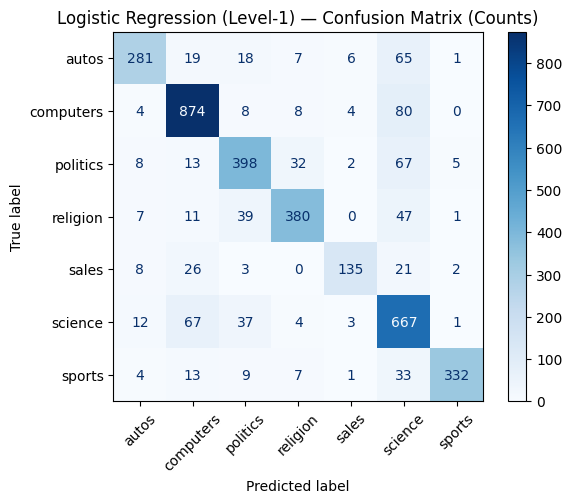

<Figure size 600x500 with 0 Axes>

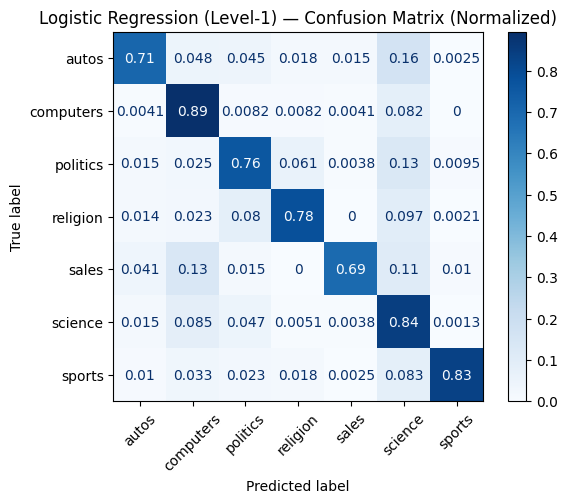

In [6]:
# === Classification Report & Confusion Matrix for Logistic Regression (Level-1) ===
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Classification Report
print("=== Classification Report (Logistic Regression Level-1) ===")
print(classification_report(y_test, y_pred_lr, digits=4, target_names=le_level1.classes_))

# Confusion Matrix (raw counts)
cm = confusion_matrix(y_test, y_pred_lr, labels=clf_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_level1.classes_)
plt.figure(figsize=(6,5))
disp.plot(values_format="d", xticks_rotation=45, cmap="Blues")
plt.title("Logistic Regression (Level-1) — Confusion Matrix (Counts)")
plt.show()

# Confusion Matrix (normalized per true class)
cm_norm = confusion_matrix(y_test, y_pred_lr, labels=clf_lr.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=le_level1.classes_)
plt.figure(figsize=(6,5))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Logistic Regression (Level-1) — Confusion Matrix (Normalized)")
plt.show()


In [7]:
clf_svm = SVC(kernel='linear', probability=True)
clf_svm.fit(X_train, y_train)

y_pred_svm = clf_svm.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print("✅ SVM Level-1 Accuracy:", acc_svm)

with open("level1_svm.pkl", "wb") as f:
    pickle.dump(clf_svm, f)

✅ SVM Level-1 Accuracy: 0.8124668435013263


=== Classification Report (SVM Level-1) ===
              precision    recall  f1-score   support

       autos     0.8314    0.7078    0.7646       397
   computers     0.8749    0.8865    0.8807       978
    politics     0.7637    0.7695    0.7666       525
    religion     0.8753    0.7670    0.8176       485
       sales     0.8817    0.7641    0.8187       195
     science     0.6741    0.8420    0.7487       791
      sports     0.9818    0.8120    0.8889       399

    accuracy                         0.8125      3770
   macro avg     0.8404    0.7927    0.8123      3770
weighted avg     0.8244    0.8125    0.8144      3770



<Figure size 600x500 with 0 Axes>

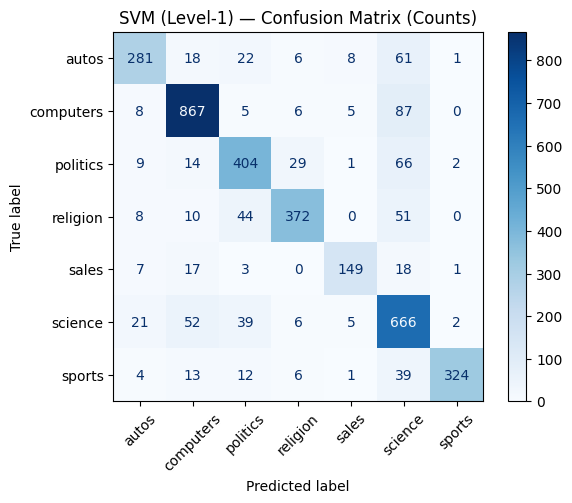

<Figure size 600x500 with 0 Axes>

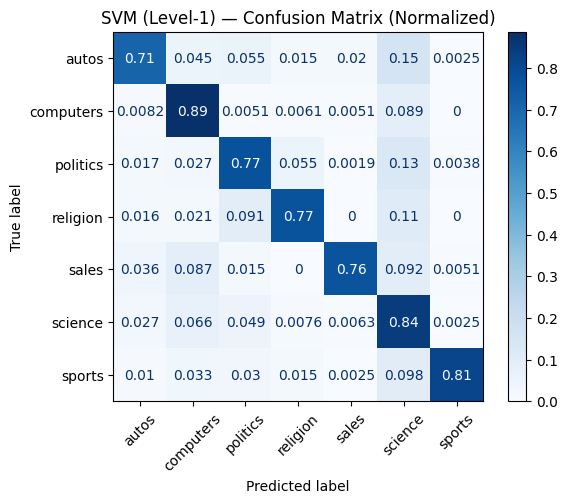

In [8]:
# Classification Report
print("=== Classification Report (SVM Level-1) ===")
print(classification_report(y_test, y_pred_svm, digits=4, target_names=le_level1.classes_))

# Confusion Matrix (raw counts)
cm = confusion_matrix(y_test, y_pred_svm, labels=clf_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_level1.classes_)
plt.figure(figsize=(6,5))
disp.plot(values_format="d", xticks_rotation=45, cmap="Blues")
plt.title("SVM (Level-1) — Confusion Matrix (Counts)")
plt.show()

# Confusion Matrix (normalized per true class)
cm_norm = confusion_matrix(y_test, y_pred_svm, labels=clf_svm.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=le_level1.classes_)
plt.figure(figsize=(6,5))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("SVM (Level-1) — Confusion Matrix (Normalized)")
plt.show()


In [9]:
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("✅ Random Forest Level-1 Accuracy:", acc_rf)

with open("level1_rf.pkl", "wb") as f:
    pickle.dump(clf_rf, f)

✅ Random Forest Level-1 Accuracy: 0.749867374005305


=== Classification Report (Random Forest Level-1) ===
              precision    recall  f1-score   support

       autos     0.8251    0.6297    0.7143       397
   computers     0.7012    0.9192    0.7956       978
    politics     0.6958    0.6971    0.6965       525
    religion     0.8314    0.7216    0.7726       485
       sales     0.8794    0.6359    0.7381       195
     science     0.7060    0.6587    0.6815       791
      sports     0.8830    0.7945    0.8364       399

    accuracy                         0.7499      3770
   macro avg     0.7888    0.7224    0.7479      3770
weighted avg     0.7597    0.7499    0.7477      3770



<Figure size 600x500 with 0 Axes>

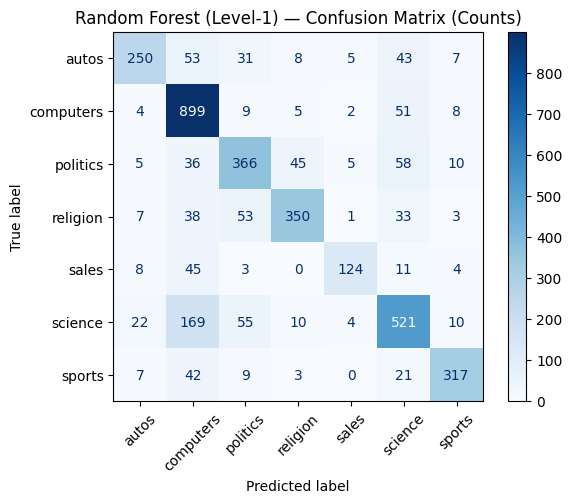

<Figure size 600x500 with 0 Axes>

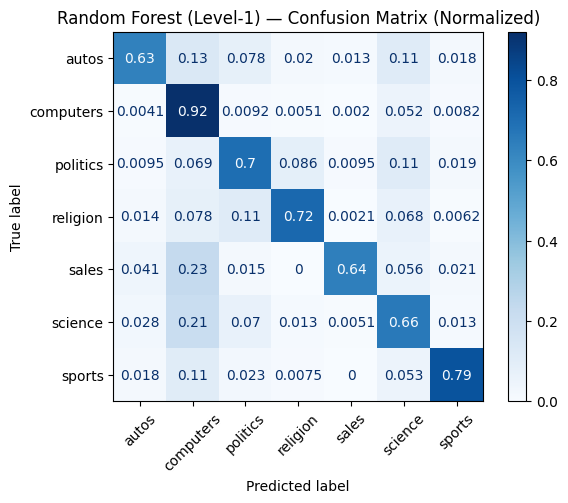

In [10]:
#Classification Report & Confusion Matrix for Random Forest (Level-1)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Classification Report
print("=== Classification Report (Random Forest Level-1) ===")
print(classification_report(y_test, y_pred_rf, digits=4, target_names=le_level1.classes_))

# Confusion Matrix (raw counts)
cm = confusion_matrix(y_test, y_pred_rf, labels=clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_level1.classes_)
plt.figure(figsize=(6,5))
disp.plot(values_format="d", xticks_rotation=45, cmap="Blues")
plt.title("Random Forest (Level-1) — Confusion Matrix (Counts)")
plt.show()

# Confusion Matrix (normalized per true class)
cm_norm = confusion_matrix(y_test, y_pred_rf, labels=clf_rf.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=le_level1.classes_)
plt.figure(figsize=(6,5))
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Random Forest (Level-1) — Confusion Matrix (Normalized)")
plt.show()

In [11]:
groups = le_level1.classes_

for group in groups:
    print(f"Training fine models for group: {group}")

    df_group = df[df["level1"] == group]

    if df_group["category"].nunique() == 1:
        print(f" - Only one subcategory ({df_group['category'].iloc[0]}). Skipping.")
        continue

    X_group = vectorizer.transform(df_group["text"])

    le_fine = LabelEncoder()
    y_group = le_fine.fit_transform(df_group["category"])

    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
        X_group, y_group, test_size=0.2, random_state=42, stratify=y_group
    )

    # Train Logistic Regression
    clf_lr_fine = LogisticRegression(max_iter=1000)
    clf_lr_fine.fit(X_train_f, y_train_f)

    y_pred_fine_lr = clf_lr_fine.predict(X_test_f)
    acc_fine_lr = accuracy_score(y_test_f, y_pred_fine_lr)
    print(f"✅ Fine LR accuracy for {group}: {acc_fine_lr:.4f}")

    with open(f"fine_lr_{group}.pkl", "wb") as f:
        pickle.dump(clf_lr_fine, f)

    # Train SVM
    clf_svm_fine = SVC(kernel='linear')
    clf_svm_fine.fit(X_train_f, y_train_f)

    y_pred_fine_svm = clf_svm_fine.predict(X_test_f)
    acc_fine_svm = accuracy_score(y_test_f, y_pred_fine_svm)
    print(f"✅ Fine SVM accuracy for {group}: {acc_fine_svm:.4f}")

    with open(f"fine_svm_{group}.pkl", "wb") as f:
        pickle.dump(clf_svm_fine, f)

    # Train Random Forest
    clf_rf_fine = RandomForestClassifier(n_estimators=100)
    clf_rf_fine.fit(X_train_f, y_train_f)

    y_pred_fine_rf = clf_rf_fine.predict(X_test_f)
    acc_fine_rf = accuracy_score(y_test_f, y_pred_fine_rf)
    print(f"✅ Fine RF accuracy for {group}: {acc_fine_rf:.4f}")

    with open(f"fine_rf_{group}.pkl", "wb") as f:
        pickle.dump(clf_rf_fine, f)

    # Save label encoder
    with open(f"fine_encoder_{group}.pkl", "wb") as f:
        pickle.dump(le_fine, f)

Training fine models for group: autos
✅ Fine LR accuracy for autos: 0.8744
✅ Fine SVM accuracy for autos: 0.8593
✅ Fine RF accuracy for autos: 0.8342
Training fine models for group: computers
✅ Fine LR accuracy for computers: 0.7426
✅ Fine SVM accuracy for computers: 0.7375
✅ Fine RF accuracy for computers: 0.7130
Training fine models for group: politics
✅ Fine LR accuracy for politics: 0.8248
✅ Fine SVM accuracy for politics: 0.8267
✅ Fine RF accuracy for politics: 0.8038
Training fine models for group: religion
✅ Fine LR accuracy for religion: 0.6928
✅ Fine SVM accuracy for religion: 0.7052
✅ Fine RF accuracy for religion: 0.6371
Training fine models for group: sales
 - Only one subcategory (misc.forsale). Skipping.
Training fine models for group: science
✅ Fine LR accuracy for science: 0.8799
✅ Fine SVM accuracy for science: 0.8609
✅ Fine RF accuracy for science: 0.8104
Training fine models for group: sports
✅ Fine LR accuracy for sports: 0.9273
✅ Fine SVM accuracy for sports: 0.909

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def eval_fine_model(name, model, y_true, y_pred, le_fine, group):
    """Print a classification report and show count & normalized confusion matrices for one fine model."""
    # Text report (nice labels)
    print(f"\n=== {name} — Classification Report (group: {group}) ===")
    print(classification_report(y_true, y_pred, digits=4, target_names=le_fine.classes_))

    # Confusion matrix labels must be the encoded class integers that the model was trained on
    labels = getattr(model, "classes_", np.unique(y_true))
    # Display labels as human-readable class names
    display_labels = le_fine.inverse_transform(labels)

    # Raw counts
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    plt.figure(figsize=(6,5))
    disp.plot(values_format="d", xticks_rotation=45, colorbar=False)
    plt.title(f"{name} — Confusion Matrix (Counts) | {group}")
    plt.tight_layout()
    plt.show()

    # Row-normalized
    cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=display_labels)
    plt.figure(figsize=(6,5))
    disp.plot(xticks_rotation=45, colorbar=True)
    plt.title(f"{name} — Confusion Matrix (Normalized) | {group}")
    plt.tight_layout()
    plt.show()


=== Fine Logistic Regression — Classification Report (group: sports) ===
                    precision    recall  f1-score   support

rec.sport.baseball     0.8899    0.9749    0.9305       199
  rec.sport.hockey     0.9724    0.8800    0.9239       200

          accuracy                         0.9273       399
         macro avg     0.9311    0.9274    0.9272       399
      weighted avg     0.9312    0.9273    0.9272       399



<Figure size 600x500 with 0 Axes>

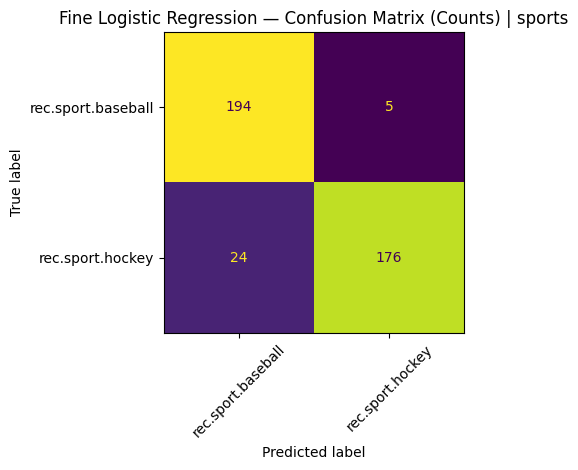

<Figure size 600x500 with 0 Axes>

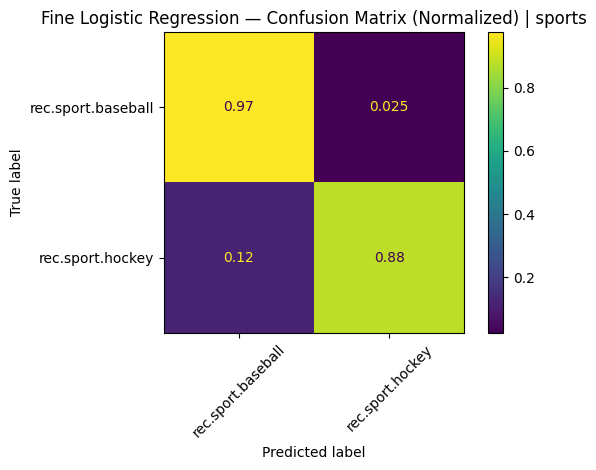


=== Fine SVM — Classification Report (group: sports) ===
                    precision    recall  f1-score   support

rec.sport.baseball     0.8721    0.9598    0.9139       199
  rec.sport.hockey     0.9556    0.8600    0.9053       200

          accuracy                         0.9098       399
         macro avg     0.9139    0.9099    0.9096       399
      weighted avg     0.9140    0.9098    0.9096       399



<Figure size 600x500 with 0 Axes>

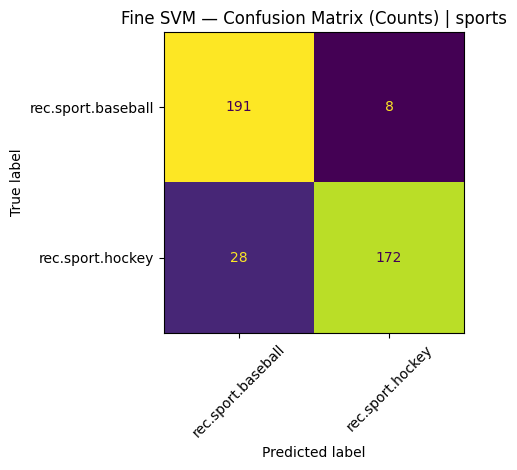

<Figure size 600x500 with 0 Axes>

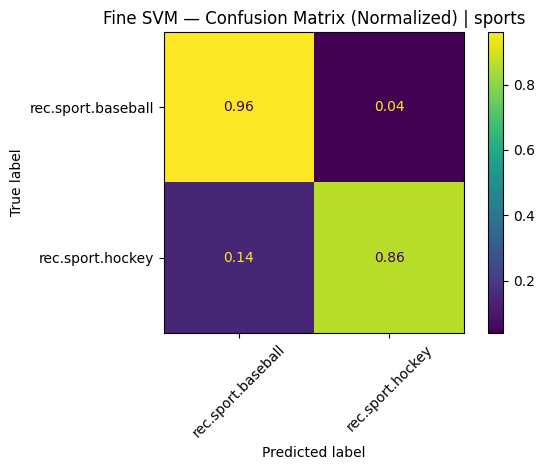


=== Fine Random Forest — Classification Report (group: sports) ===
                    precision    recall  f1-score   support

rec.sport.baseball     0.8767    0.9648    0.9187       199
  rec.sport.hockey     0.9611    0.8650    0.9105       200

          accuracy                         0.9148       399
         macro avg     0.9189    0.9149    0.9146       399
      weighted avg     0.9190    0.9148    0.9146       399



<Figure size 600x500 with 0 Axes>

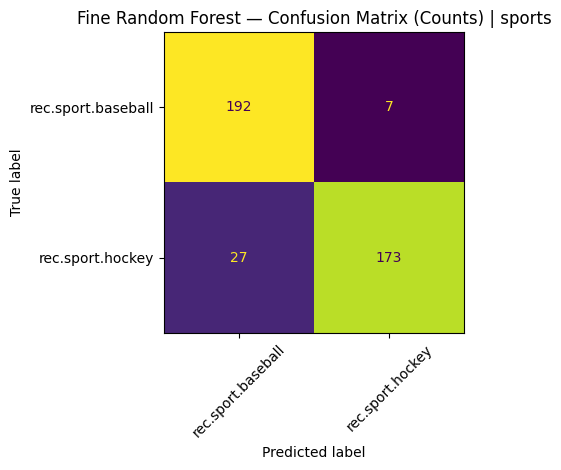

<Figure size 600x500 with 0 Axes>

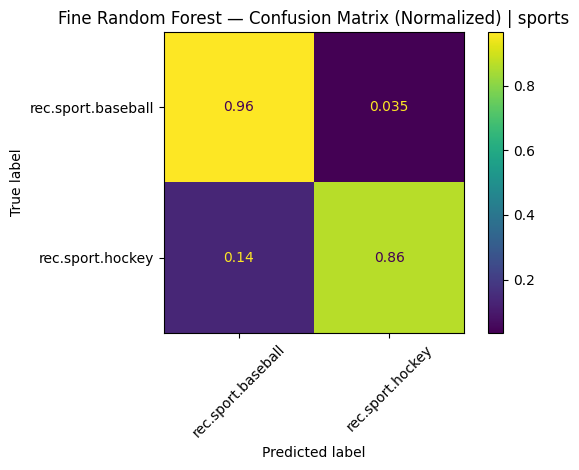

In [13]:
# After y_pred_fine_lr is computed:
eval_fine_model("Fine Logistic Regression", clf_lr_fine, y_test_f, y_pred_fine_lr, le_fine, group)

# After y_pred_fine_svm is computed:
eval_fine_model("Fine SVM", clf_svm_fine, y_test_f, y_pred_fine_svm, le_fine, group)

# After y_pred_fine_rf is computed:
eval_fine_model("Fine Random Forest", clf_rf_fine, y_test_f, y_pred_fine_rf, le_fine, group)

In [ ]:
# Example text
new_text = "The patient was diagnosed with a rare neurological condition requiring treatment."

X_new = vectorizer.transform([new_text])

# Predict Level-1
pred_lr = clf_lr.predict(X_new)[0]
group_lr = le_level1.inverse_transform([pred_lr])[0]
print("✅ Level-1 Prediction (LR):", group_lr)

# Check if fine model exists
fine_model_path = f"fine_lr_{group_lr}.pkl"
encoder_path = f"fine_encoder_{group_lr}.pkl"

if os.path.exists(fine_model_path) and os.path.exists(encoder_path):
    with open(fine_model_path, "rb") as f:
        fine_model = pickle.load(f)
    with open(encoder_path, "rb") as f:
        fine_encoder = pickle.load(f)

    fine_pred = fine_model.predict(X_new)[0]
    fine_label = fine_encoder.inverse_transform([fine_pred])[0]

    print("✅ Fine-grained Prediction:", fine_label)
else:
    print("✅ No fine model exists; using Level-1 prediction only.")

✅ Level-1 Prediction (LR): science
✅ Fine-grained Prediction: sci.med
